# Exploring Shuffling Methods

I play a lot of card games, and am always worried about how well I shuffle. Whenever I deal up a new hand and get what seems like an unlikely sequence of cards, I can't help but question whether I've shuffled the cards enough. What are the best methods of shuffling and how many times do I need to shuffle a deck before it should be considered randomized?

I'm going to try to answer these questions by exploring different methods of shuffling through some simulations. I may also actually shuffle up some cards physically to see how effectively I can put theory into practice.

Note that I'm sure plenty of other people have done this kind of thing, and a quick Google or YouTube search could give me all of the answers I'm looking for. But it seemed like more fun to find the answers myself, so here I go.

In [1]:
import sys

import numpy as np
%matplotlib widget 
from matplotlib import pyplot as pl

sys.path.append('../src/')
import shufflers as s

I'm going to run my analysis against a 60 card deck, common in several TCGs including [Flesh and Blood's](https://fabtcg.com) Classic Constructed format, which is what I'm playing most these days.

Let's start with an unshuffled deck, which I'll represent as an array of integers encoding the starting position of each card in the deck (starting from position 0).

In [2]:
fresh_deck = np.arange(60)

In [3]:
fresh_deck

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

I've implemented several shuffler classes (see accompanying module for details), each with a `shuffle` method that take in a deck, shuffles it *once* according to the shuffling strategy implemented in the class, and returns a new array with the shuffled cards. Here is an implementation of a class that shuffles by cutting a deck roughly in half, then exchanges the order of the two halves.

In [4]:
shuffler = s.CutShuffler()
shuffler.shuffle(fresh_deck)

array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24])

I'm not sure the best way to measure how well a deck has been shuffled, but one way that I thought of is to count at the difference in positions between two cards that were next to one another before shuffling. For example, in the `fresh_deck` above, cards 0 and 1 start next to one another. After shuffling, we can measure the absolute difference between the shuffled positions of cards 0 and 1. For a perfectly shuffled deck, we would expect this distance to follow a specific distribution. What is that distribution?

The smallest distance between cards is 1 and the largest is the size of the deck minus 1 (59 in this case).

I would expect a higher probability of measuring a small distance than a large distance because there are more configurations where short distances are possible than large distances. Consider the following example for a 5 card deck.

There are 8 possible configurations for cards 0 and 1 to be 1 position apart.
```
0 1 X X X
X 0 1 X X
X X 0 1 X
X X X 0 1
1 0 X X X
X 1 0 X X
X X 1 0 X
X X X 1 0
```

There are 6 possible configurations for cards 0 and 1 to be 2 positions apart.
```
0 X 1 X X
X 0 X 1 X
X X 0 X 1
1 X 0 X X
X 1 X 0 X
X X 1 X 0
```

There are 4 possible configurations for cards 0 and 1 to be 3 positions apart.
```
0 X X 1 X
X 0 X X 1
1 X X 0 X
X 1 X X 0
```

There are 2 possible configurations for cards 0 and 1 to be 4 positions apart.
```
0 X X X 1
1 X X X 0
```


So the probability distribution for distance between two cards would look like

```
*
* *
* * *
* * * *
1 2 3 4
```

Counting out different configurations, for a perfectly randomized deck we should expect a linear decrease in probability from the minimum distance of 1 to the maximum given that for each larger distance there are fewer possible configurations where two cards can be separated by the given distance.

Here I've written a function to calculate this distribution for a given deck size. Let's look at some statistics and plot the distribution.



Let's go ahead and simulate shuffling up some cards, compute final distances between two initially neighboring cards, and compare to this ideal distribution. 

To help understand what's going on, I've got a couple of methods here to visualize how well shuffled the deck is after N shuffles. We will look at the histogram of distances between our marked card and its neighbor after N shuffles. We will also look at quantiles of the distribution over N shuffles to more easily see how the distribution evolves.

In [51]:
def plot_histograms(distances, true_x=None, true_dist=None): 
    
    keys=[1, 2, 3, 5, 8, 13]
    
    f = pl.figure(figsize=(9, 9))
    for i,k in enumerate(keys):
        pl.subplot(320 + i + 1) 
        pl.hist(distances[k], bins=np.arange(1, 60), label="Simulated")
        pl.title(f"{k} Shuffles")
        if true_x is not None:
            pl.plot(true_x, true_dist * len(distances[k]), '--k', alpha=0.5, label='Ideal')
        if i == 0:
            pl.legend(loc=0)
        if i >= len(keys) - 2:
            pl.xlabel("Card separation")
    pl.tight_layout();

In [47]:
def plot_sim_summary(sim_results, ideal_sim_results=None):

    stats = {"mean": [], "median": [], "5th": [], "25th": [], "75th": [], "95th": []}
    n_shuffles = sorted(sim_results.keys())
    for shuffle_num in n_shuffles:
        stats["median"].append(np.median(sim_results[shuffle_num]))
        stats["mean"].append(np.mean(sim_results[shuffle_num]))
        for q, q_label in zip([0.05, 0.25, 0.75, 0.95], ["5th", "25th", "75th", "95th"]):
            stats[q_label].append(np.quantile(sim_results[shuffle_num], q))

    pl.figure(figsize=(9, 6))
    pl.plot(n_shuffles, stats["mean"], "r", alpha=0.7, label='Sim Mean')
    pl.plot(n_shuffles, stats["5th"], ":r", alpha=0.7, label='Sim 5th & 95th')
    pl.plot(n_shuffles, stats["25th"], "--r", alpha=0.7, label='Sim 25th & 75th')
    pl.plot(n_shuffles, stats["75th"], "--r", alpha=0.7)
    pl.plot(n_shuffles, stats["95th"], ":r", alpha=0.7)
    
    pl.xlabel("Number of shuffles")
    pl.ylabel("Distance between adjacent cards")
    
    if ideal_sim_results is not None:
        pl.axhline(ideal_stats["mean"], c='k', alpha=0.7, label='Ideal Mean')
        pl.axhline(ideal_stats["25th"], ls='--', c='k', alpha=0.7, label='Ideal 5th & 95th')
        pl.axhline(ideal_stats["75th"], ls='--', c='k', alpha=0.7, label='Ideal 25th & 75th')
        pl.axhline(ideal_stats["5th"], ls=':', c='k', alpha=0.7)
        pl.axhline(ideal_stats["95th"], ls=':', c='k', alpha=0.7)
    pl.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    pl.tight_layout();
    
    return stats

This function computes the probability that two cards will be n spaces apart in the deck. 

Let's start by looking at a "perfect shuffler" that completely randomizes the deck each shuffle.

In [44]:
ideal_sim_results = s.simulate_shuffling(fresh_deck, s.IdealShuffler)

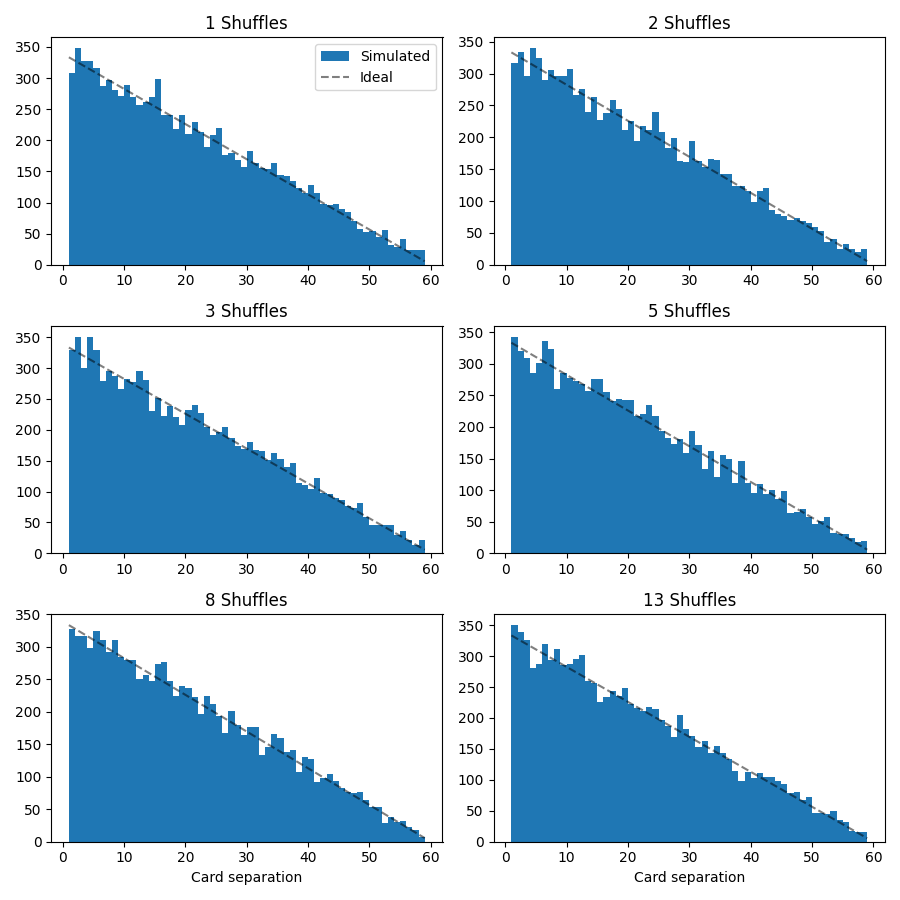

In [52]:
plot_histograms(ideal_sim_results, x, p)

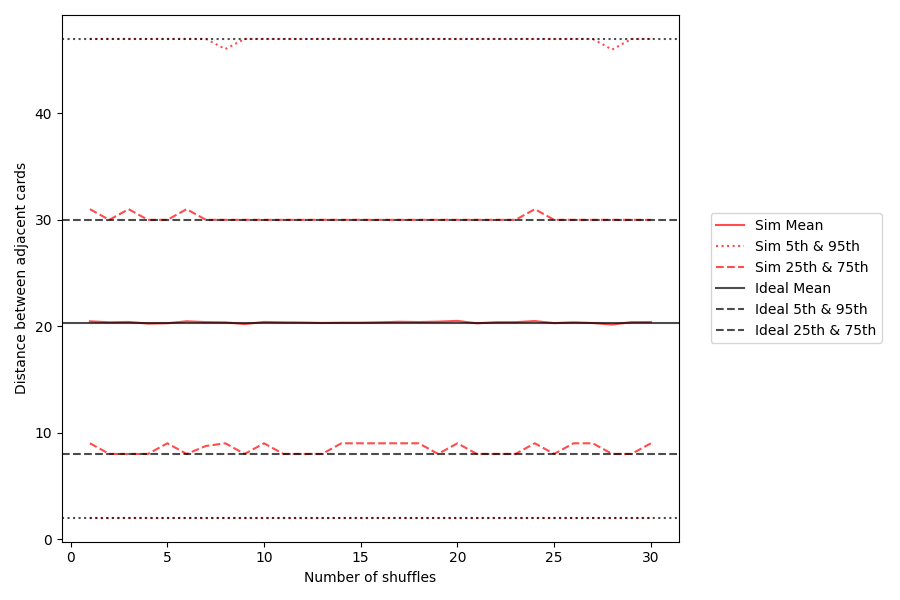

In [48]:
ideal_sim_stat_trends = plot_sim_summary(ideal_sim_results, ideal_sim_results)

We see the linear decrease in probability for each distance as expected. The simulated results match the true distribution (shown as a dashed line) quite closely. With more simulations, I would expect this to get closer and closer to the ideal.

Of course, we get a perfectly randomized deck after just a single shuffle with this method, but we need a computer for this method of randomizing our cards.

Let's compare this to "riffle shuffling", where you cut a deck in half, then somewhat randomly interleave the cards from the two halves back together. 

I've simulated riffle shuffling with a random distribution of the number of cards inserted into the new deck from one half before switching back to introduce cards from the other. The distribution I draw from is as follows:

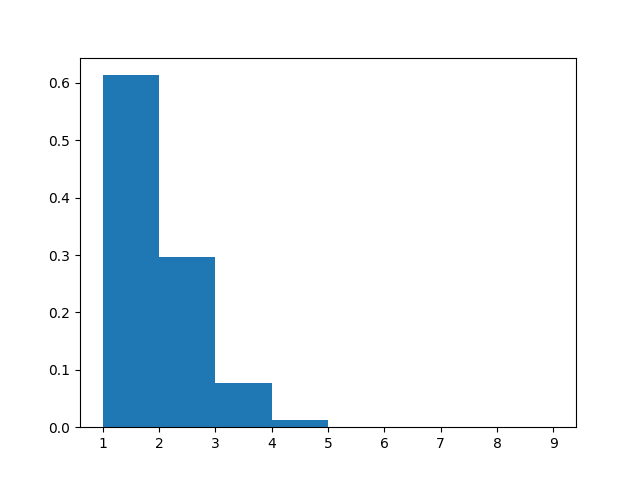

In [18]:
pl.figure()
pl.hist((np.random.poisson(0.5, size=10000) + 1), bins=np.arange(1, 10), density=True);

This distribution says that about 60% of the time we'll take one card from one half before switching back to take a card from the next half. Around 30% of the time we'll get two cards from one half before switching back to the other. Rarely we'll get a larger number of cards from one half in a row. 

Note that I'm not distinguishing between real "riffle shuffling" like you would do with a deck of playing cards and the type of "smash together" shuffling that TCG players more commonly do with a deck of sleeved cards. I think the mechanisms are pretty much the same unless I'm not thinking about it correctly.

In [23]:
riffle_sim_results = s.simulate_shuffling(fresh_deck, s.RiffleShuffler)

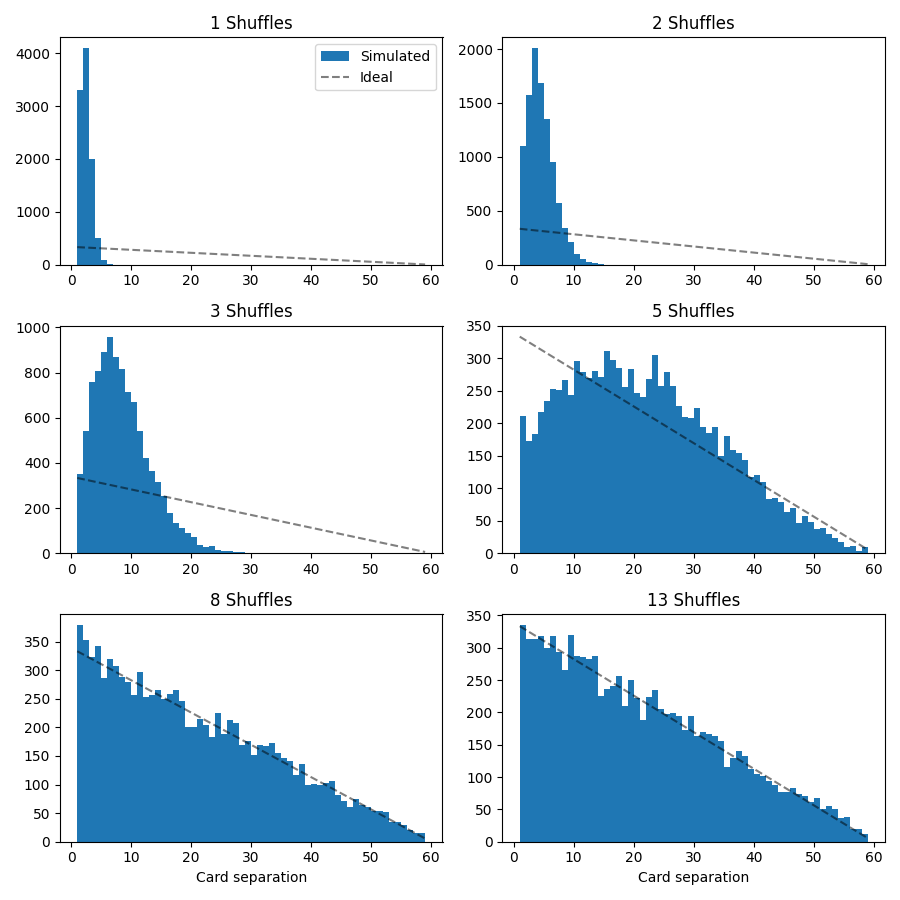

In [53]:
plot_histograms(riffle_sim_results, x, p)

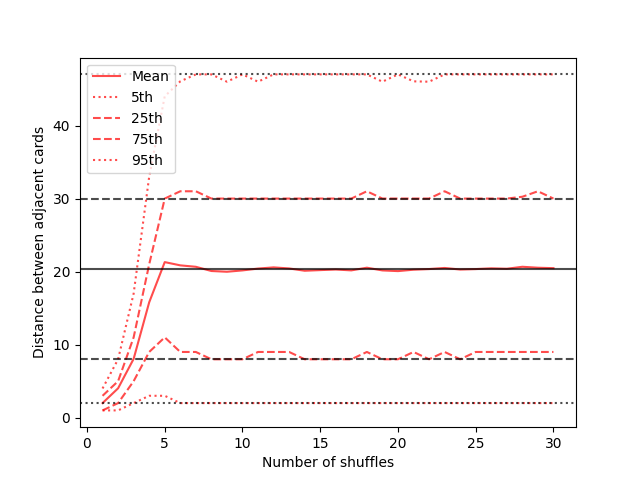

In [25]:
_ = plot_sim_summary(riffle_sim_results, ideal_stats)

After only one or two riffle shuffles, cards that are initially close to one another tend to stay quite close to one another. It takes a number of shuffles to allow cards to drift apart. So if you don't shuffle enough times, you will expect to see cards that started next to one another still clumped together in your shuffled deck. 

Comparing the distribution of card separations to the ideal distribution, it looks like it takes somewhere between 5 and 8 shuffles, I would say 6-7 based on the trends of quantiles, to get a randomized distribution using the riffle shuffling method. 

My perception of riffle shuffling with physical cards is that it takes a lot more than this to actually fully shuffle the deck, and I usually shuffle dozens of times before feeling comfortable dealing out a hand. Do I not execute the riffle shuffle as simulated here? Or am I bad at recognizing randomness (as humans generally are)?

Let's turn to pile shuffling. This is something a lot of TCG players do to shuffle their cards gently. It involves dealing out cards into some number of piles, then re-assembling the piles *in a random order*. Note that dealing cards out sequentially and picking them up sequentially does not randomize the deck at all. My implementation of pile shuffling here is different than what I usually do, which is "randomly" deal cards into piles *and* randomly pick up the piles. Here I'm not randomly dealing, just randomly picking up.

In [26]:
pile_7_sim_results = s.simulate_shuffling(fresh_deck, s.RandomPickupPileShuffler, n_piles=7)

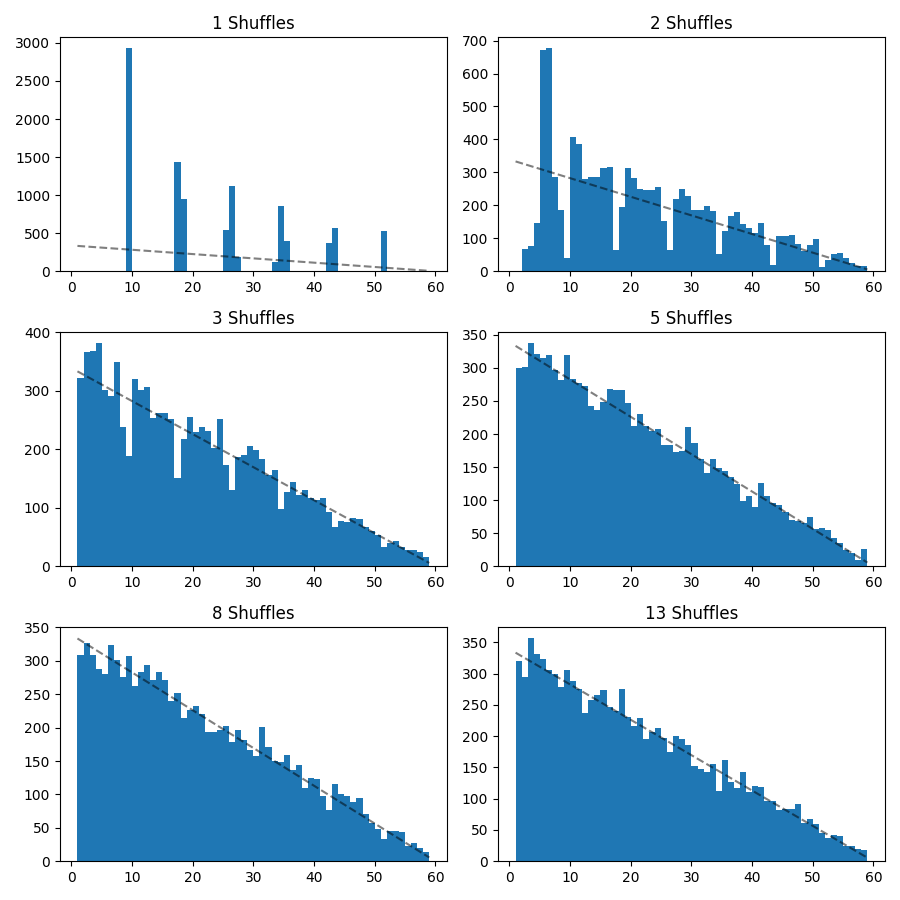

In [27]:
plot_histograms(pile_7_sim_results, x, p)

/tmp/ipykernel_3315/1294994965.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  pl.figure(figsize=(9, 6))


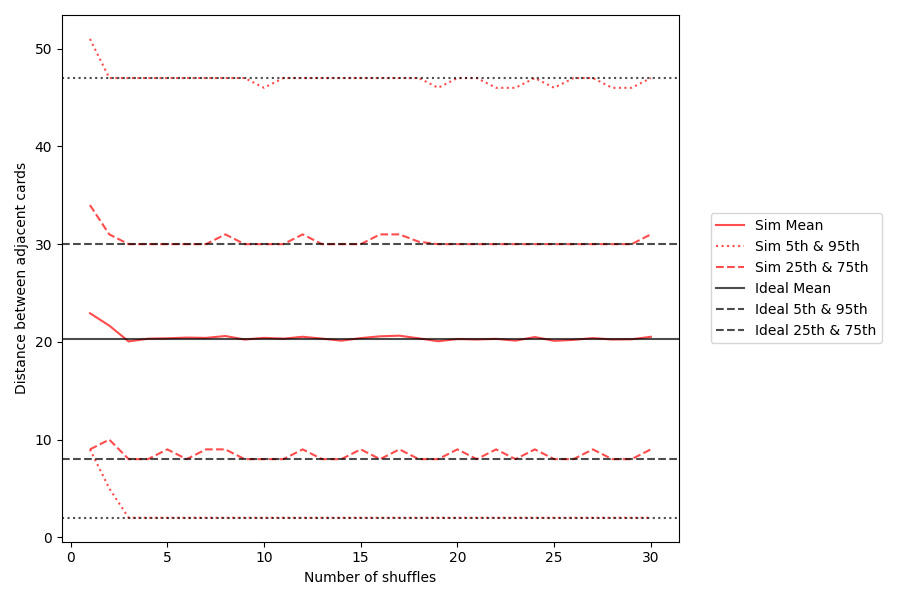

In [54]:
_ = plot_sim_summary(pile_7_sim_results, ideal_stats)

With this method, we start with a very limited number of distances between cards, but unlike with riffle shuffling, we're distributing cards better across the range of possible separations. The initially "spikey" distribution persists for a few shuffles but eventually cards spread out throughout the deck.

Surprisingly (to me), this seems to achieve randomness with fewer shuffles than riffle shuffling, seemingly around 4-5 shuffles. 

This result depends critically on the number of piles. Let's see what happens when we only use 3 piles.

In [29]:
pile_3_sim_results = s.simulate_shuffling(fresh_deck, s.RandomPickupPileShuffler, n_piles=3)

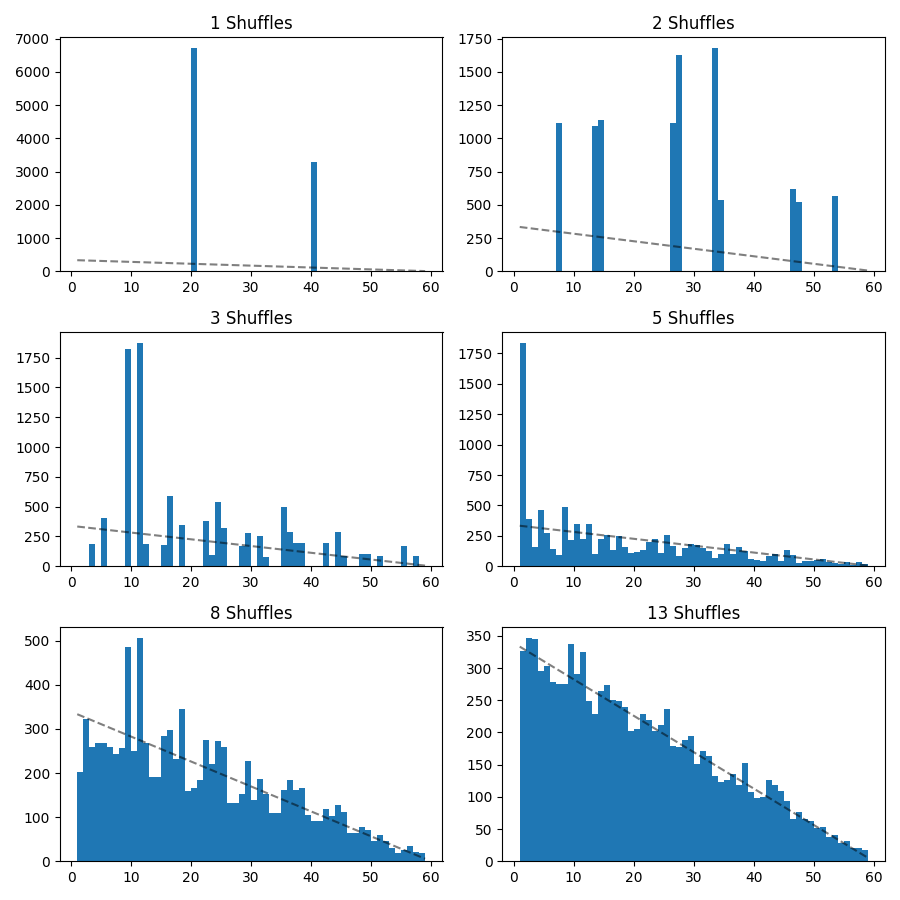

In [30]:
plot_histograms(pile_3_sim_results, x, p)

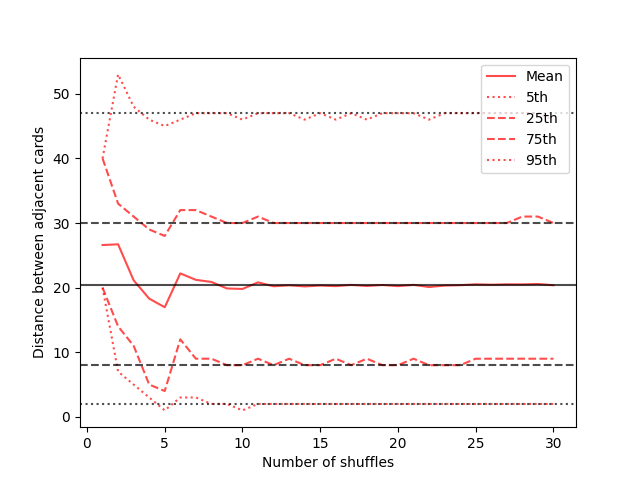

In [31]:
_ = plot_sim_summary(pile_3_sim_results, ideal_stats)

In this case we need more than 10 shuffles to get a randomized deck.

Pile shuffling gets you a result with fewer shuffles than riffle shuffling, but riffle shuffling is faster to execute so you can do more of them in the same amount of time. 

Something that I do and I see a lot of others do is do a single pile shuffle, then riffle shuffle a number of times before dealing out. Does this go faster than just riffle shuffling?

In [58]:
pile_then_riffle_sim_results = s.simulate_shuffling(fresh_deck, s.PileThenRiffleShuffler)

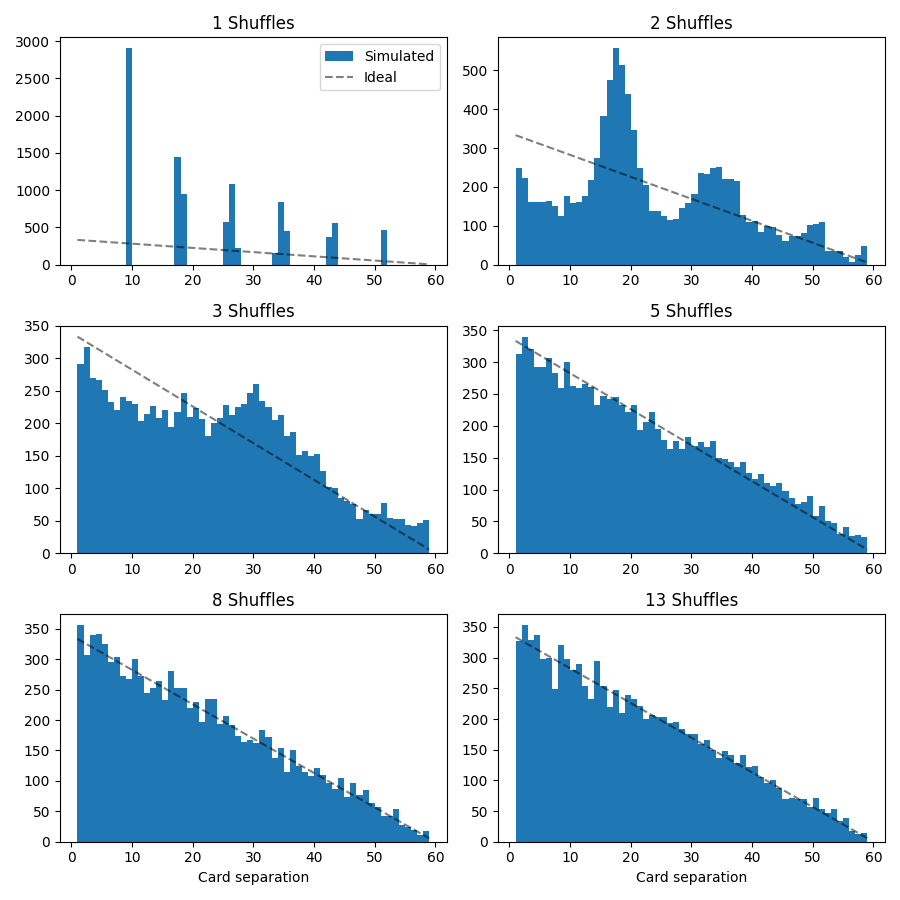

In [59]:
plot_histograms(pile_then_riffle_sim_results, x, p)

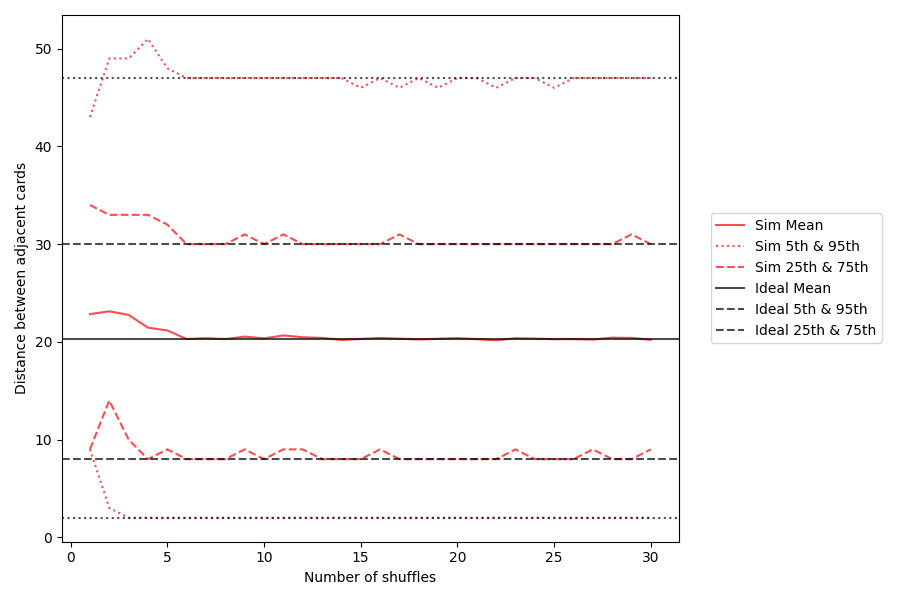

In [61]:
_ = plot_sim_summary(pile_then_riffle_sim_results, ideal_stats)

A bit, yes. It seems like we get something more like 5 shuffles (1 pile + 3-4 riffle) compared to 6-7 shuffles for pure riffle shuffling. This is the same number of shuffles as pile shuffling, but riffle shuffling is faster, so this might be the fastest approach? 


In [62]:
riffle_sim_results_mid = s.simulate_shuffling(fresh_deck, s.RiffleShuffler, marked_card=29)

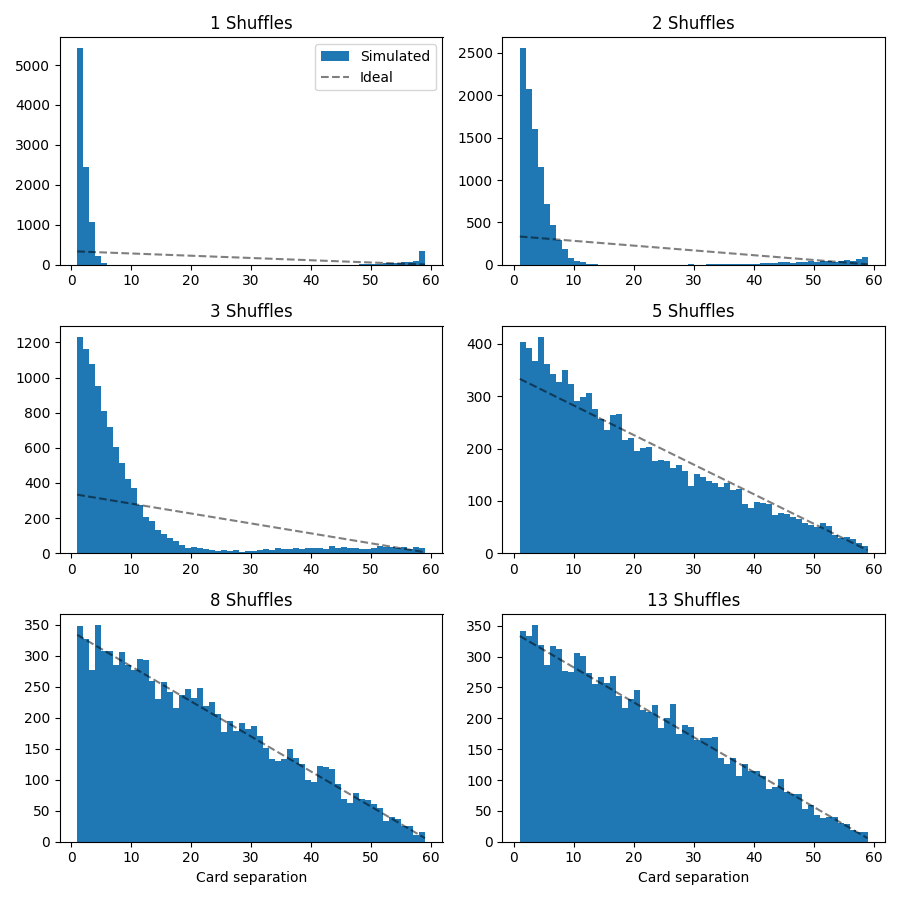

In [63]:
plot_histograms(riffle_sim_results_mid, x, p)

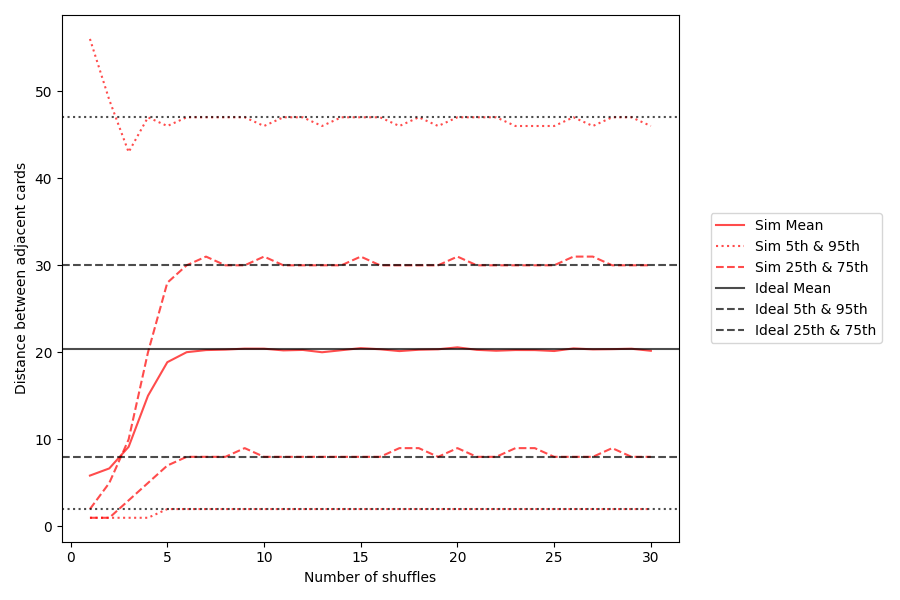

In [64]:
_ = plot_sim_summary(riffle_sim_results_mid, ideal_sim_results)

In [65]:
pile_sim_results_mid = s.simulate_shuffling(fresh_deck, s.RandomPickupPileShuffler, marked_card=29)

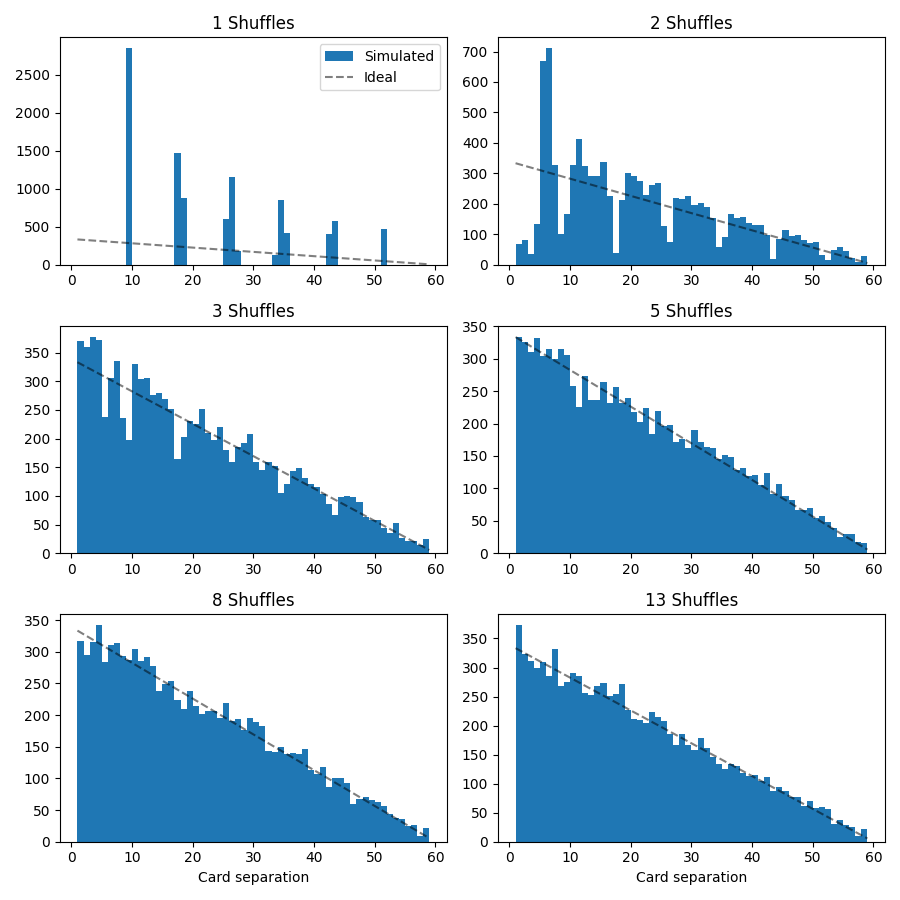

In [66]:
plot_histograms(pile_sim_results_mid, x, p)

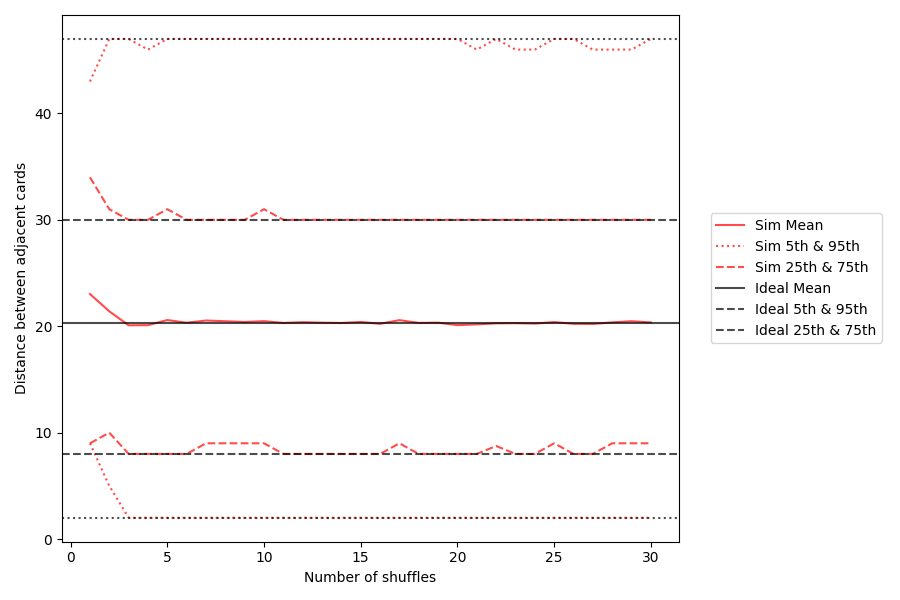

In [67]:
_ = plot_sim_summary(pile_sim_results_mid, ideal_sim_results)

I'm feeling pretty good about using distance between a marked card and its neighbor in a deck as a measure of how well the deck is shuffled. We can see some useful trends and results visually above. So far I'm learning that pile shuffling, in terms of # of shuffles, is quite effective, and likely easier to reliably execute physically. Riffle shuffling takes more shuffles but is faster to perform per shuffle and is likely faster overall, but I don't know how sensitive results are to my assumptions in the simulations?

- How do results compare for different marked cards? Is adjacent card distance the right way to measure randomness?
    - They are different for sure, at least for riffle shuffling. It seems to take one more shuffle to get fully randomized compared to two adjacent cards at the edge of the deck initially.
- How do the parameters (overlap, distribution of interleaved card count, etc.) for riffle shuffling impact results?
- How does physical shuffling compare to these results?
- Can I compute a metric to tell me when I'm perfectly shuffled?
- What is the optimal number of piles for a pile shuffle?

In [125]:
def kl_divergence(p, q):
    return np.sum(p * np.log(p / q))

In [126]:
def get_dist(d):
    test, _ = np.histogram(d, np.arange(1, 61))
    return test / np.sum(test)

In [140]:
def get_kl_divs(result_set):
    kl_divs = []
    for k in result_set:
        this_dist = get_dist(result_set[k])
        kl_divs.append(kl_divergence(this_dist, p))
    return kl_divs

In [141]:
ideal_kl_divs = get_kl_divs(ideal_sim_results)

In [143]:
print(f"{np.mean(ideal_kl_divs):.4f} +- {np.std(ideal_kl_divs) * 2:.4f}")

0.0029 +- 0.0011


In [158]:
riffle_kl_divs = get_kl_divs(riffle_sim_results)
riffle_kl_divs_mid = get_kl_divs(riffle_sim_results_mid)
pile_7_kl_divs = get_kl_divs(pile_7_sim_results)
pile_7_kl_divs_mid = get_kl_divs(pile_sim_results_mid)
pile_then_riffle_kl_divs = get_kl_divs(pile_then_riffle_sim_results)

/tmp/ipykernel_1049/1126516936.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(p * np.log(p / q))
/tmp/ipykernel_1049/1126516936.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(p * np.log(p / q))


In [150]:
n_shuffles = sorted(riffle_sim_results.keys())

(0.0, 0.1)

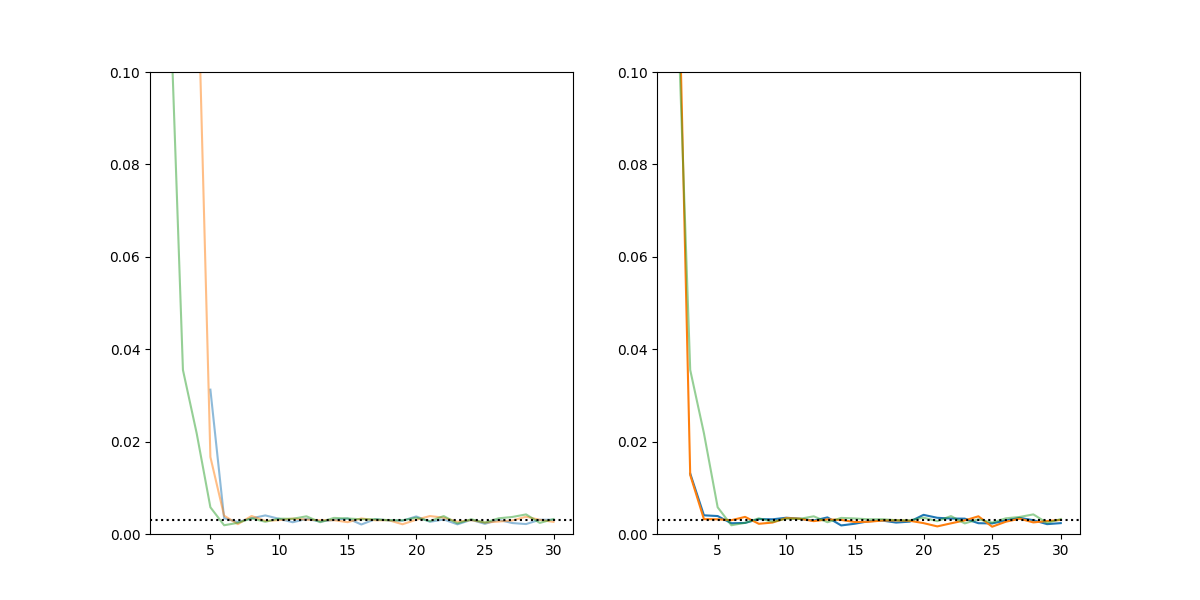

In [163]:
pl.figure(figsize=(12, 6))
pl.subplot(121)
pl.plot(n_shuffles, riffle_kl_divs, alpha=0.5)
pl.plot(n_shuffles, riffle_kl_divs_mid, alpha=0.5)
pl.plot(n_shuffles, pile_then_riffle_kl_divs, alpha=0.5)
pl.axhline(np.mean(ideal_kl_divs), ls=':', c='k')
pl.ylim([0, 0.1])
pl.subplot(122)
pl.plot(n_shuffles, pile_7_kl_divs)
pl.plot(n_shuffles, pile_7_kl_divs_mid)
pl.plot(n_shuffles, pile_then_riffle_kl_divs, alpha=0.5)
pl.axhline(np.mean(ideal_kl_divs), ls=':', c='k')
pl.ylim([0, 0.1])